In [1]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

In [2]:
f = open('C:/Users/Nikhil/Desktop/pest_split_dataset/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

,label,name
0,1,Dolycoris baccarum
1,2,Lycorma delicatula
2,3,Eurydema dominulus
3,4,Pieris rapae
4,5,Halyomorpha halys
5,6,Spilosoma obliqua
6,7,Graphosoma rubrolineata
7,8,Luperomorpha suturalis
8,9,Leptocorisa acuta
9,10,Sesamia inferens


In [3]:
train_df = pd.read_csv('C:/Users/Nikhil/Desktop/pest_split_dataset/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('C:/Users/Nikhil/Desktop/pest_split_dataset/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('C:/Users/Nikhil/Desktop/pest_split_dataset/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

,image_path,label
0,003_4009.jpg,0
1,003_4011.jpg,0
2,003_4013.jpg,0
3,003_4014.jpg,0
4,003_4016.jpg,0


In [4]:
TRAIN_DIR = 'C:/Users/Nikhil/Desktop/pest_split_dataset/train'
TEST_DIR = 'C:/Users/Nikhil/Desktop/pest_split_dataset/test'
VAL_DIR = 'C:/Users/Nikhil/Desktop/pest_split_dataset/val'
LR = 2e-5
BATCH_SIZE = 8
EPOCH = 2

device = torch.device('cuda')

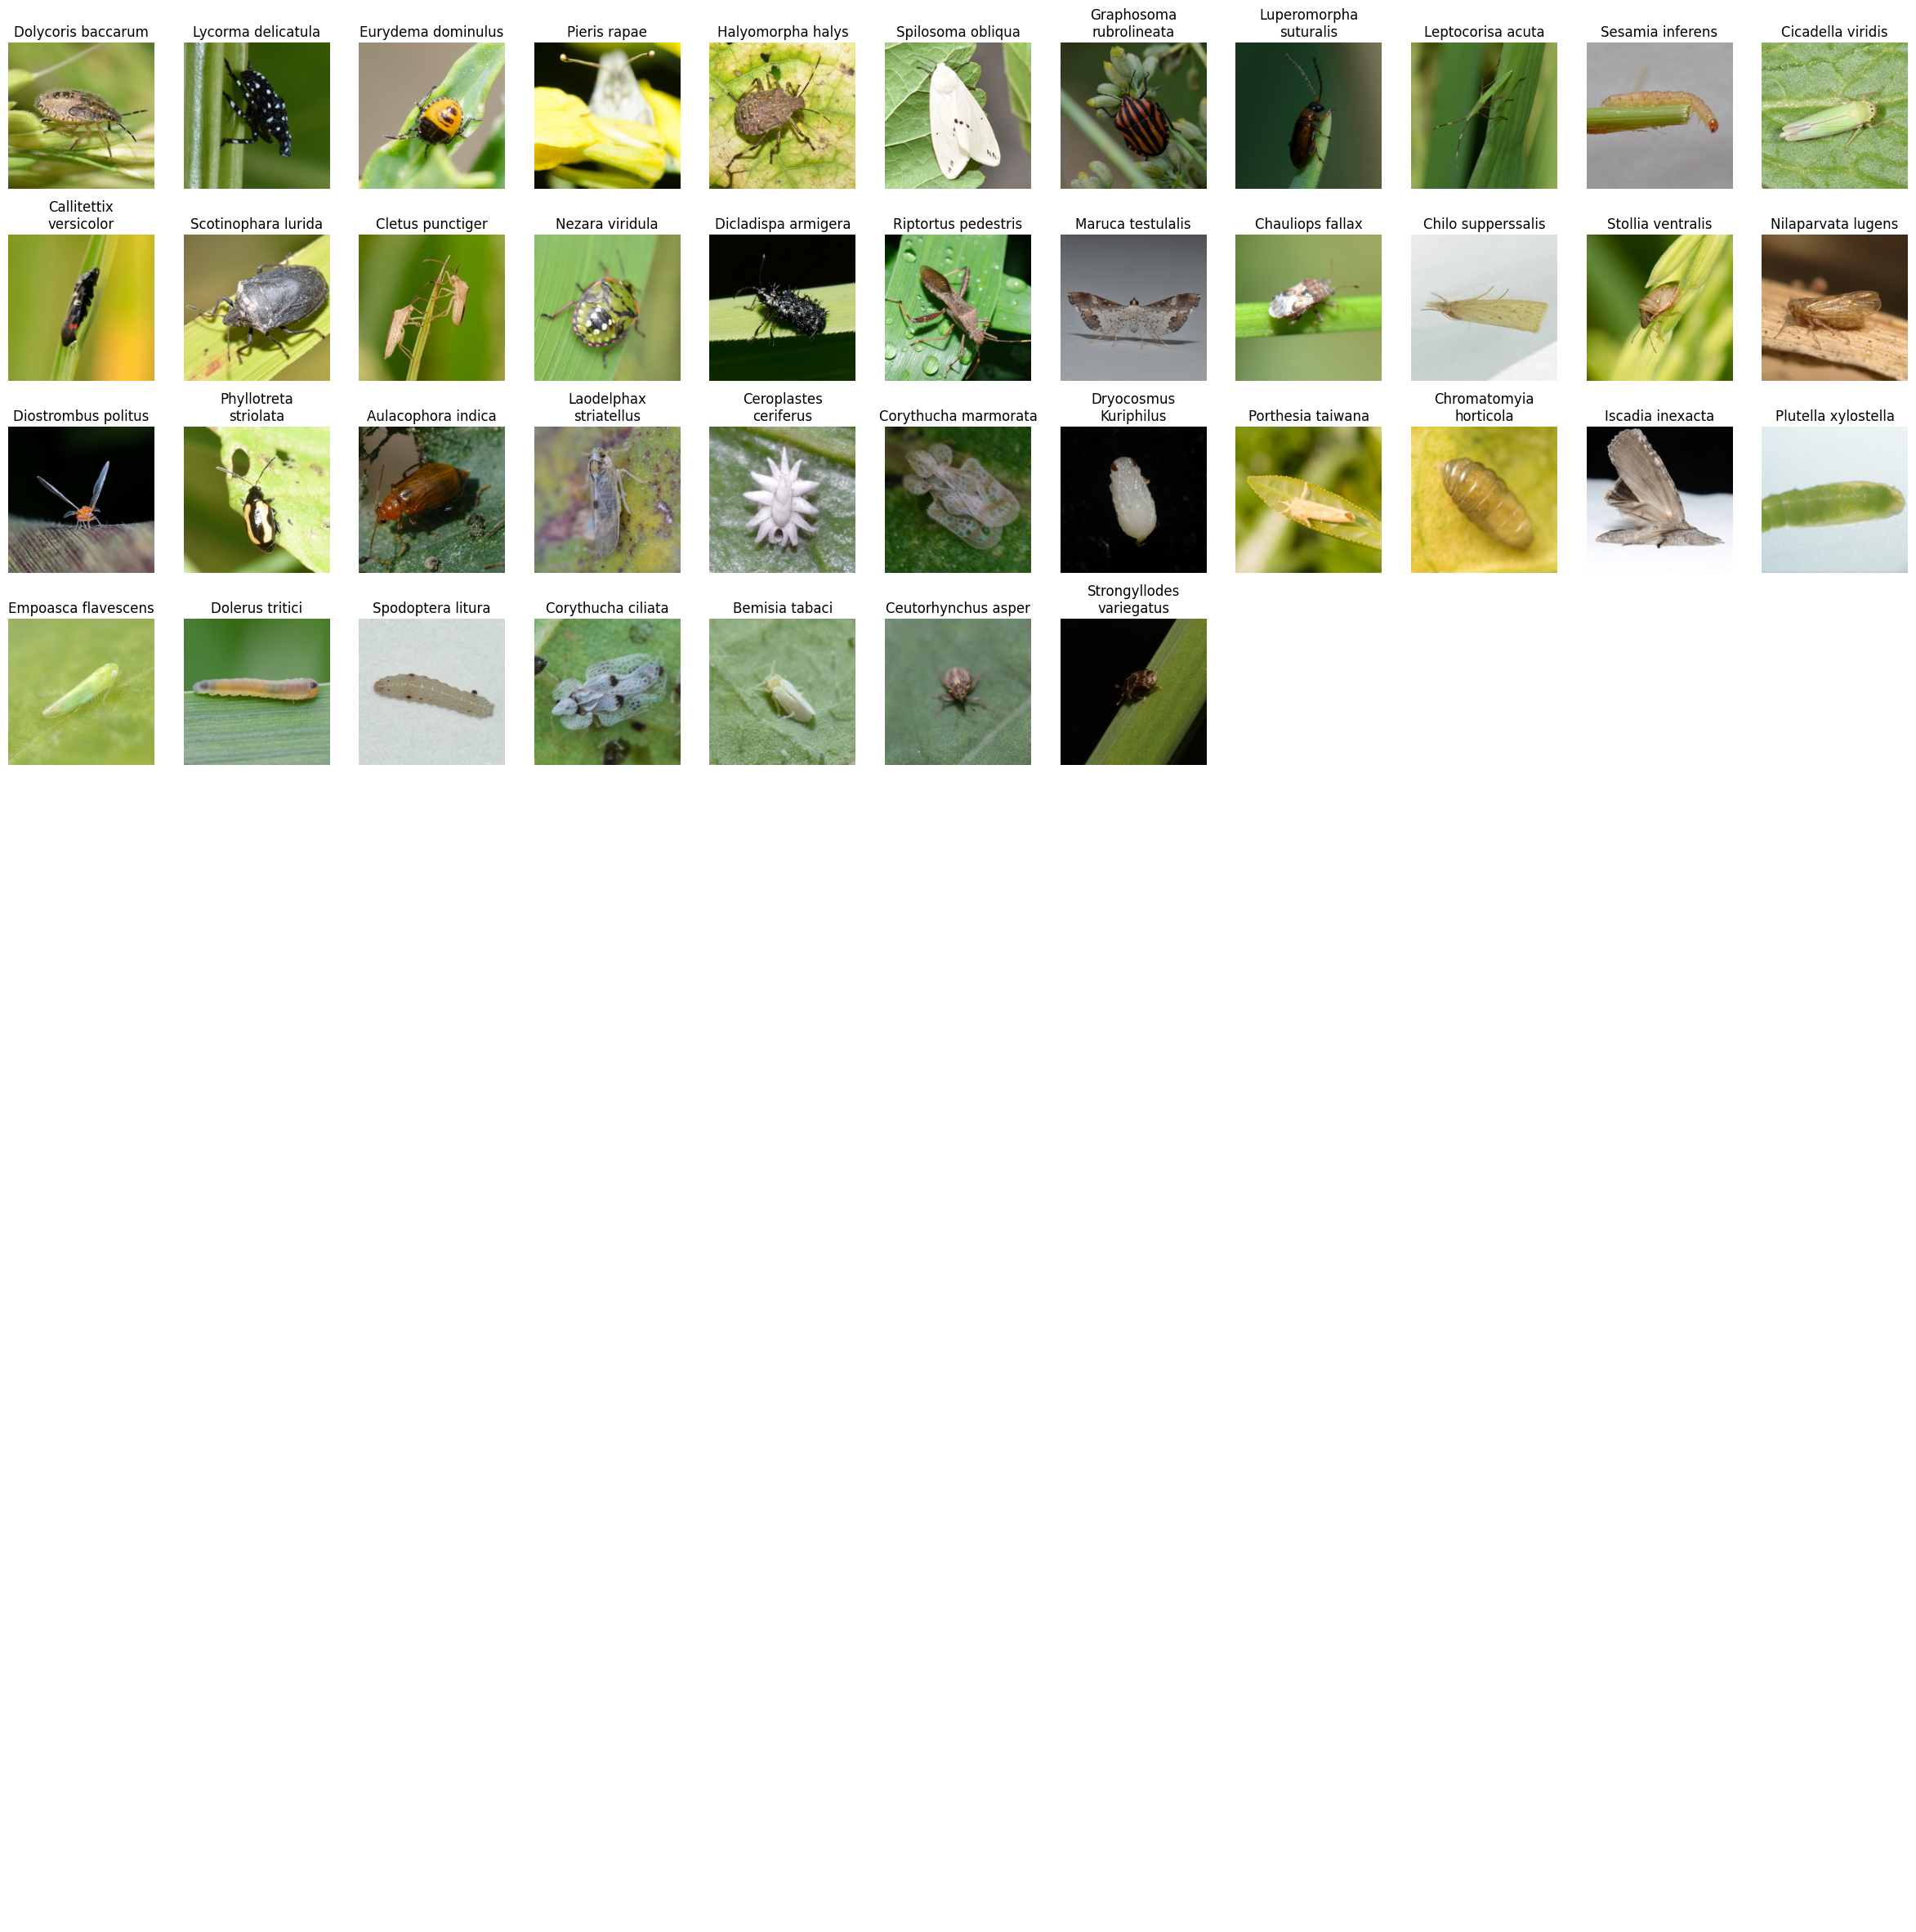

In [5]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [6]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [7]:
def train_transform():
    return A.Compose([
        A.HorizontalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(224, 224),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2()])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        try:
            image = cv2.imread(os.path.join(self.imgdir, str(image_info[1]), image_info[0]), cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError(f"Unable to read image at index {index}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
            image /= 255.

            if self.transforms is not None:
                image = self.transforms(image=image)['image']

            label = image_info[1]

            image = torch.as_tensor(image, dtype=torch.float32)
            label = torch.as_tensor(label, dtype=torch.long)

            return image, label

        except Exception as e:
            print(f"Error processing image at index {index}: {str(e)}")
        # You might want to handle the error by returning default placeholders or skipping the image
        # Example:
        # image = np.zeros((width, height, channels), dtype=np.float32)  # Set a placeholder image
        # label = -1  # Set a placeholder label
        # return torch.tensor(image), torch.tensor(label)


In [10]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=train_transform())
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=valid_transform())
val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=0)

In [11]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [12]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary


In [13]:
os.environ['WANDB_CONSOLE'] = 'off'

def run():
    model = InsectModel(num_classes=40)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    best_loss = 10**5
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f}')

In [14]:
run()

100%|█████████████████████████████████████████████████| 85/85 [00:08<00:00,  9.49it/s, acc=0.981, epoch=1, loss=0.0425]


Epoch 001: | Train Loss: 0.49595 | Val Loss: 0.04249


100%|█████████████████████████████████████████████████| 85/85 [00:08<00:00, 10.15it/s, acc=0.985, epoch=2, loss=0.0223]


Epoch 002: | Train Loss: 0.03213 | Val Loss: 0.02229


### Accuracy : 99.5%

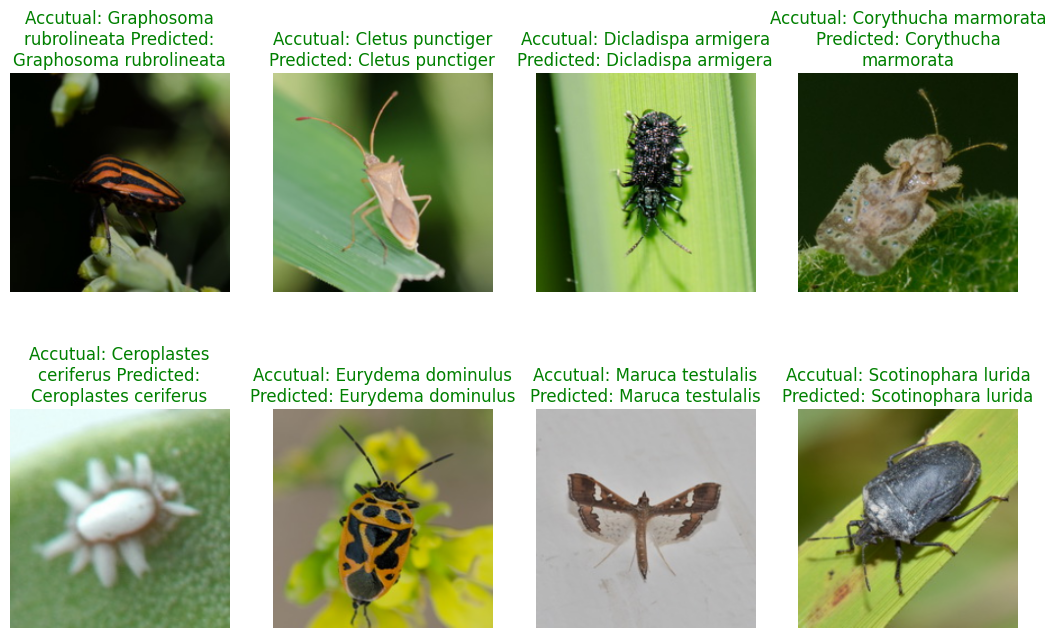

In [15]:
model = InsectModel(num_classes=40)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,8))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()